In [2]:
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.io import imread
from matplotlib import pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import operator
from random import randint

In [3]:
leaves_dir = Path().resolve().parent / "data" / "leaves"
leaves_classes = [(1, 66), (67, 126), (127, 186)]
leaves_paths = {i :[leaves_dir / 'image_{num:04d}.jpg'.format(num=j) for j in range(*ran)] for i, ran in enumerate(leaves_classes)}

In [4]:
def show_img(img):
    """
    Helper function to display using opencv
    """
    cv2.imshow('image',img)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()

# Testing each step

In [5]:
example_leaf_dir = leaves_dir / 'image_{num:04d}.jpg'.format(num=randint(1, 186))
img = cv2.imread(str(example_leaf_dir),1)
show_img(img)

In [6]:
_,g,_ = cv2.split(img)

### Comparing edge detection with various methods of threshold and without

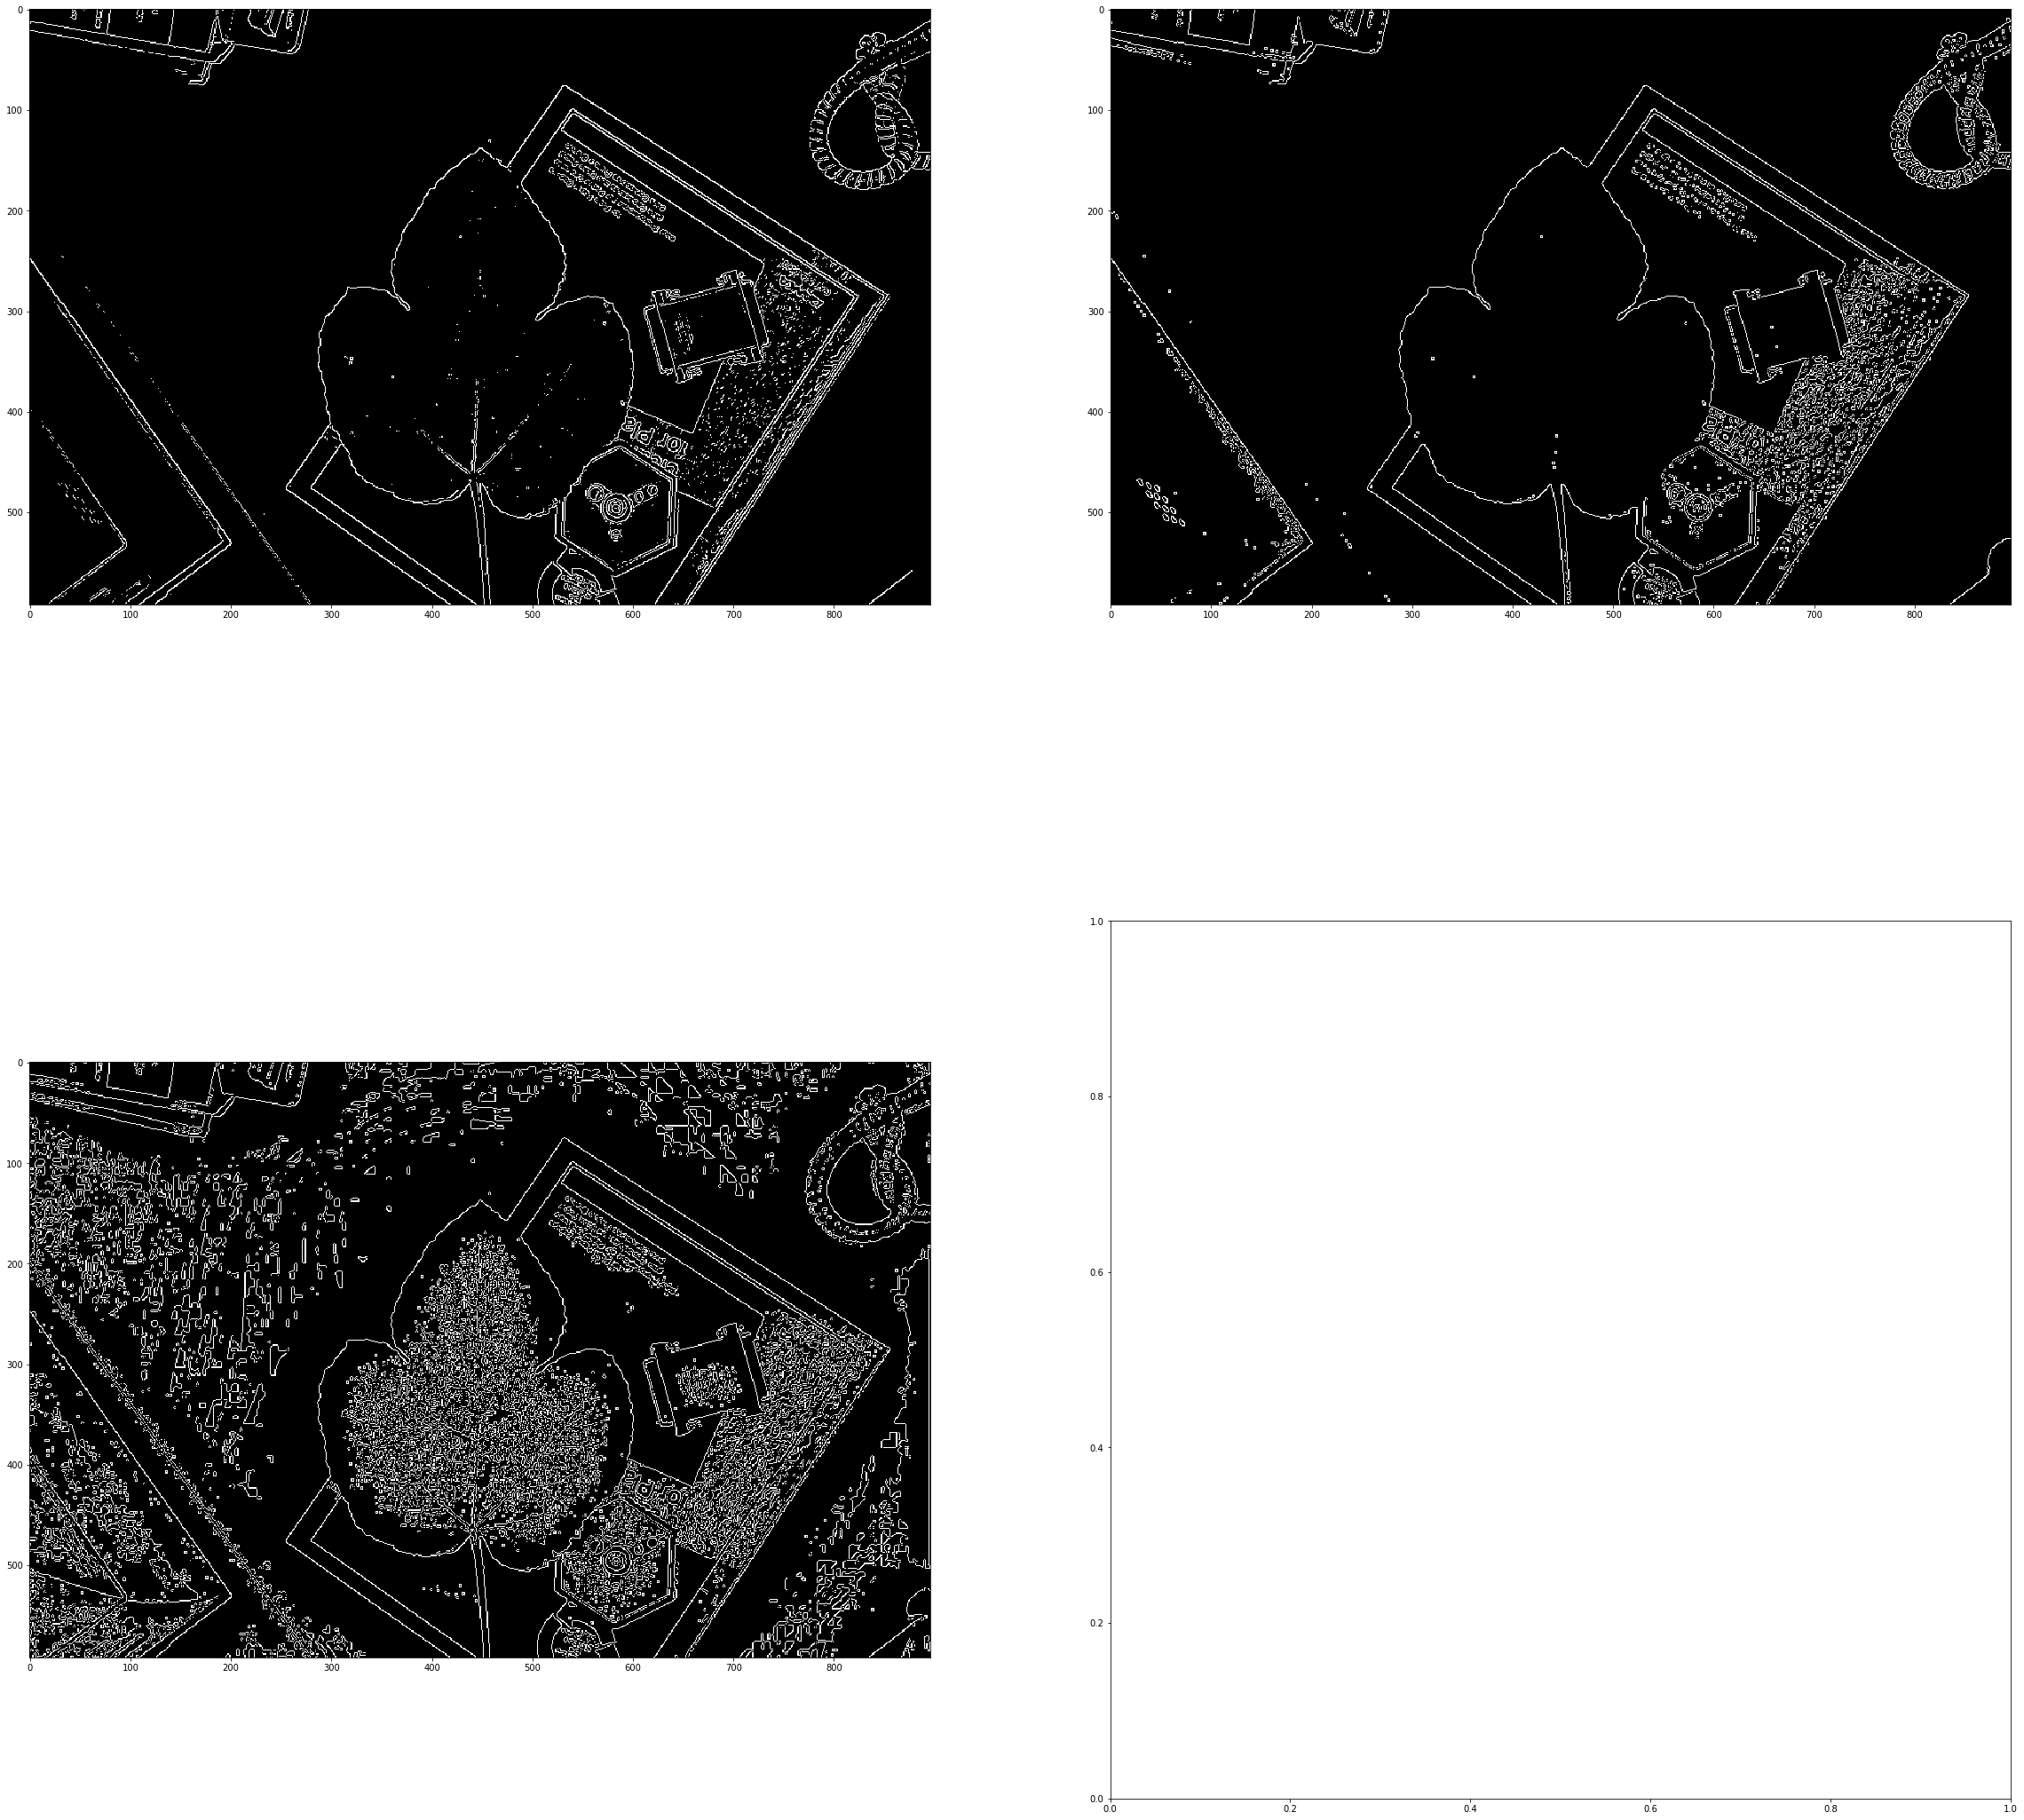

In [7]:
th, dst = cv2.threshold(g,125,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th2 = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)

edges_g = cv2.Canny(g,250,250)
edges_thresh1 = cv2.Canny(dst,300,300)
edges_thresh2 = cv2.Canny(th2,300,300)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(40,40))
ax1.imshow(edges_g, cmap="gray")
ax2.imshow(edges_thresh1, cmap="gray")
ax3.imshow(edges_thresh2, cmap="gray")

plt.figure(figsize=(1,50))
plt.show()

In [43]:
edges = cv2.Canny(g,250,250)
show_img(edges)

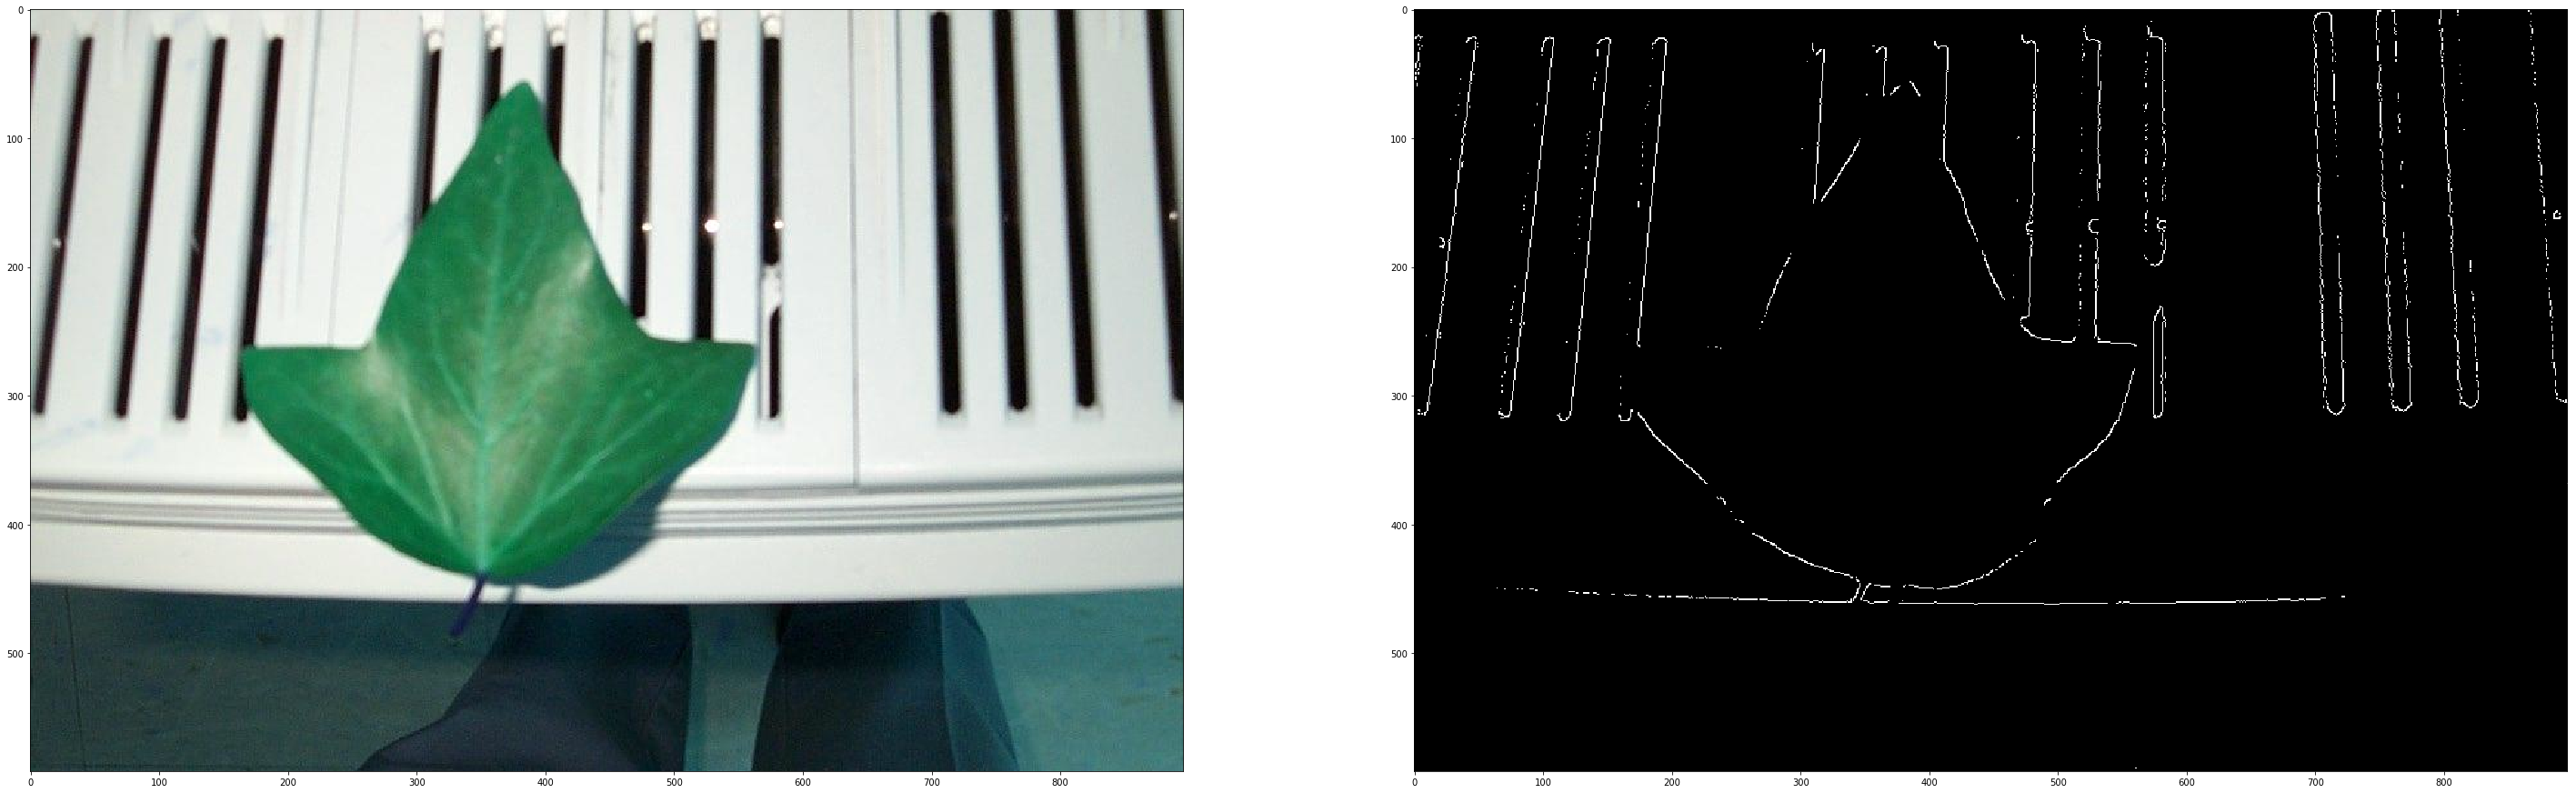

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50,100))
ax1.imshow(img)
ax2.imshow(edges, cmap="gray")
plt.figure(figsize=(1,50))
plt.show()

In [133]:
# Tesing skeletonization
def skele(img):
    skel = np.zeros(img.shape,np.uint8)
    size = np.size(img)
    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel
a = skele(edges)
show_img(a)

# Applying whole process

In [97]:
h, w = 50, 50

In [114]:
def preprocess(path: Path) -> np.array:
    """
    Preprocess applied to each photo.
    Return preprocessed photo as a numpy array.
    """
    img = cv2.imread(str(example_leaf_dir),1)
    _,g,_ = cv2.split(img)
    edges = cv2.Canny(g,300,300)
    reshaped = cv2.resize(edges, (h, w))
    return reshaped

In [115]:
#testing
ex = leaves_paths[0][1]
show_img(preprocess(ex))

In [99]:
def generate_x_y_dataset(leaves_paths):
    x, y = [], []
    for id,paths in leaves_paths.items():
        for path in paths:
            x.append(preprocess(path))
            y.append(id)
    assert len(x) == len(y)
    x = np.array(x).reshape((len(x),h*w))
    return x, y

In [100]:
x, y = generate_x_y_dataset(leaves_paths)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=21)

In [33]:
clf = svm.SVC(gamma=0.0001, C=1, kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
clf.score(X_test, y_test)

0.3684210526315789

### By cross validation

In [30]:
clf = svm.SVC(gamma=0.0001)
scores = cross_val_score(clf, x, y, cv=5)
print(scores)

[0.35135135 0.35135135 0.35135135 0.35135135 0.37142857]


### Classyfing some example from test_sample

In [41]:
clf.predict(preprocess(example_leaf_dir).reshape(-1, w*h))

array([0])

# KNN

In [101]:
max_neighbours = 40
neighbors = range(2, max_neighbours)
cv_scores = []
cv_scores2 = {}

In [102]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores2[k] = scores.mean()
    cv_scores.append(scores.mean())

The optimal number of neighbors is 2 and its mean accuracy is 0.3541666666666667 


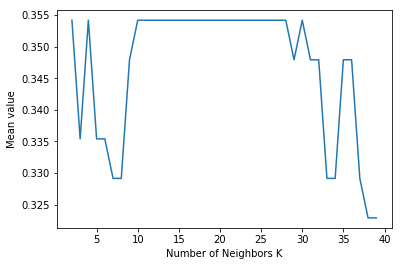

In [103]:
max_entry = max(cv_scores2.items(), key=operator.itemgetter(1))
print(f"The optimal number of neighbors is {max_entry[0]} and its mean accuracy is {max_entry[1]} ")

plt.plot(list(neighbors), list(cv_scores2.values()))
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean value')
plt.show()